In [16]:
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,
    GATConv,
    MessagePassing,
    global_mean_pool,
    global_add_pool,
)
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

In [17]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Preprocessing SMILES Data into Graphs

In [18]:
# Function to extract atom features with only Padel features
def atom_features(padel_features):
    # Padel features for the atom (assuming they are provided per atom)
    return torch.tensor(padel_features, dtype=torch.float)


# Function to extract bond features
def bond_features(bond):
    return torch.tensor(
        [bond.GetBondTypeAsDouble()], dtype=torch.float  # Bond type as a float
    )


# Convert SMILES to PyTorch Geometric Data object with Padel features
def smiles_to_graph(smiles, label, padel_features):
    mol = Chem.MolFromSmiles(smiles)

    # Atom features
    x = atom_features([padel_features])

    # Edges (bonds)
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])  # Add both directions for undirected graphs
        edge_attr.append(bond_features(bond))
        edge_attr.append(bond_features(bond))

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr)

    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


# Function to load data
def load_data(smiles_path, padel_path):
    #
    pd_smiles = pd.read_csv(smiles_path)
    smiles_list = pd_smiles["Smiles"].values
    labels = (
        pd_smiles["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0).values
    )

    #
    pd_padel = pd.read_parquet(padel_path)
    pd_padel = pd_padel.drop("Class", axis=1)
    padel_features_list = pd_padel.values

    data_list = []

    for idx, (smiles, label) in enumerate(zip(smiles_list, labels)):
        padel_features = padel_features_list[idx].tolist()

        # For test data, no augmentation, just use canonical SMILES
        graph_data = smiles_to_graph(smiles, label, padel_features)
        data_list.append(graph_data)

    return data_list

In [21]:
# Load training and testing data with Padel features
training_data = load_data(
    "data_smiles/Training_Group.csv", "data/training_class.parquet"
)
testing_data = load_data("data_smiles/Testing_Group.csv", "data/testing_class.parquet")

# Create data loaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

In [20]:
# for data in test_loader:
#     print(data)
#     break

DataBatch(x=[32, 16092], edge_index=[2, 1460], edge_attr=[1460, 1], y=[32], batch=[32], ptr=[33])


In [5]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for data in data_loader:
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
        y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [6]:
# Evaluation function with AUC and accuracy tracking
def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Move data to GPU
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
            y_pred.extend(out[:, 1].cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

# GCN approach

## 2. Define GCN Model

In [37]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Add debug print statements
        print(f"x shape: {x.shape}")
        print(f"edge_index shape: {edge_index.shape}")
        print(f"batch shape: {batch.shape}")

        # Apply graph convolution layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global pooling (average pooling) to get graph-level representations
        x = global_mean_pool(x, batch)  # Pooling over nodes in each graph

        # Final classification layer
        return F.log_softmax(self.fc(x), dim=1)

In [38]:
model = GCN(num_node_features=16092, num_classes=2).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, weight_decay=1e-4
)  # Increase weight decay value
criterion = torch.nn.CrossEntropyLoss()
data_loader = train_loader

# Training function with AUC and accuracy tracking
model.train()
total_loss = 0
correct = 0
y_true = []
y_pred = []

for data in data_loader:
    data = data.to(device)  # Move data to GPU
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    break

x shape: torch.Size([32, 16092])
edge_index shape: torch.Size([2, 1760])
batch shape: torch.Size([32])


RuntimeError: index 32 is out of bounds for dimension 0 with size 32

In [25]:
data

DataBatch(x=[32, 16092], edge_index=[2, 1596], edge_attr=[1596, 1], y=[32], batch=[32], ptr=[33])

In [27]:
x, edge_index, batch = data.x, data.edge_index, data.batch

In [29]:
x.shape

torch.Size([32, 16092])

In [32]:
edge_index.shape

torch.Size([2, 1596])

In [33]:
num_node_features = 16092
conv1 = GCNConv(num_node_features, 64)
conv1

GCNConv(16092, 64)

In [34]:
x = conv1(x, edge_index)
x

RuntimeError: index 32 is out of bounds for dimension 0 with size 32

## 3. Training Loop with Early Stopping and Metric Tracking

In [13]:
# Initialize the model, optimizer, and loss function
model = GCN(num_node_features=16092, num_classes=1).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, weight_decay=1e-4
)  # Increase weight decay value
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
max_epochs = 1000  # Max epochs
patience = 100  # Early stopping patience

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

for epoch in range(max_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    print(f"Epoch {epoch+1}:")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}"
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}"
    )

    # Early stopping
    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0  # Reset counter if improvement
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

RuntimeError: index 32 is out of bounds for dimension 0 with size 32

## 4. Evaluation function

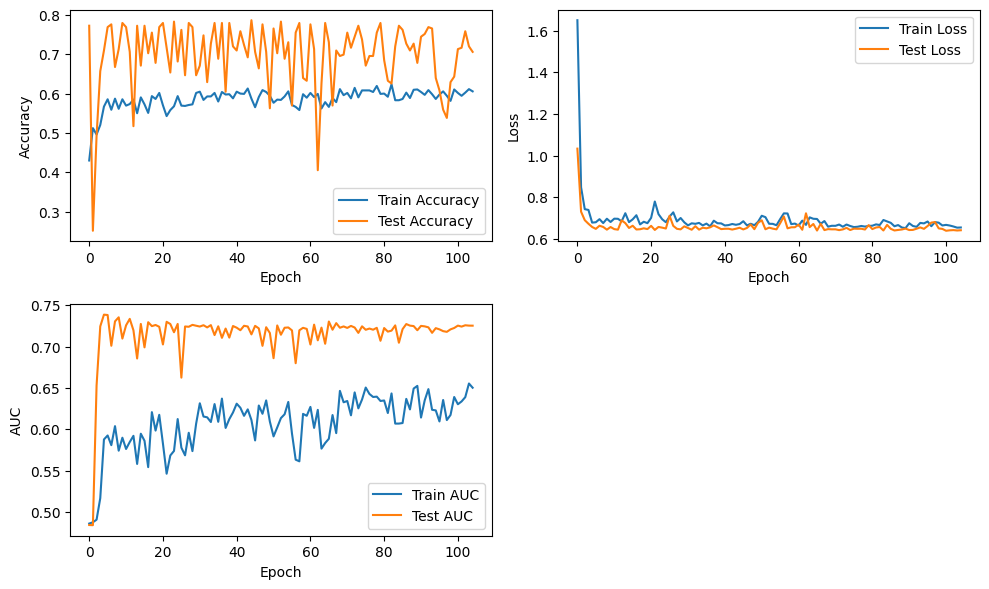

In [11]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()